# Area Detector with default HDF5 File Name

**Objective**

Demonstrate and explain the setup of an [EPICS area detector](https://areadetector.github.io/master/index.html) to acquire an image with [bluesky](https://blueskyproject.io/) and write it to an [HDF5](https://www.hdfgroup.org/solutions/hdf5) file.  Use the standard [ophyd conventions](https://blueskyproject.io/ophyd) for file naming and other setup.  Show how to retrieve the image using the [databroker](https://blueskyproject.io/databroker).

**Contents**

- [EPICS Area Detector IOC](#EPICS-Area-Detector-IOC) is pre-built
- [File Directories](#File-Directories) are different on IOC and bluesky workstation
- [ophyd](#ophyd) to describe the hardware
- [bluesky](#bluesky) for the measurement
- [databroker](#databroker) to view the image
- [punx](#punx) (not part of Bluesky) to look at the HDF5 file
- [Recapitulation](#Recapitulation) - rendition with no explanations

## EPICS Area Detector IOC

This example uses a prebuilt [ADSimDetector](https://areadetector.github.io/master/ADSimDetector/simDetector.html) driver, packaged in a [docker](https://www.docker.com/) image
([prjemian/custom-synapps-6.2-ad-3.10](https://hub.docker.com/r/prjemian/custom-synapps-6.2-ad-3.10/tags)).  The [EPICS IOC](https://docs.epics-controls.org/projects/how-tos/en/latest/getting-started/creating-ioc.html) is configured with prefix `ad:` using the [bash shell script](https://github.com/prjemian/epics-docker/blob/main/v1.1/n6_custom_areaDetector/start_adsim.sh):

```bash
user@workstation:~$ start_adsim.sh ad
```

In [1]:
IOC = "ad:"

## File Directories

Files from the IOC are mounted on the docker host in the directory `/tmp/docker_ioc/iocad`. The bluesky session runs on the docker host.

system | file directory
--- | ---
area detector IOC | `/tmp`
bluesky | `/tmp/docker_ioc/iocad/tmp`

***details***

It is important to understand that, while the EPICS IOC and the Python process where the user interacts (with bluesky and databroker) should both see the same image file written by acquisition, the directory path to that file may be different on the two systems. Typically, the file system is mounted on both (IOC & Python) at the time of acquisition, perhaps at different mount points on each. Alternatively, the image file written by the IOC may be copied to a directory where Python can find the file **when** the user attempts to read the image data via databroker.

For convenience now and later, define these two directories using [pathlib](https://docs.python.org/3/library/pathlib.html), from the Python standard library.

In [2]:
import pathlib

AD_IOC_MOUNT_PATH = pathlib.Path("/tmp")
BLUESKY_MOUNT_PATH = pathlib.Path("/tmp/docker_ioc/iocad/tmp")

Image files are written to a subdirectory (*image directory*) of the mount path.

***details***

In this case, we use a feature of the area detector [HDF5 file writer](https://areadetector.github.io/master/ADCore/NDFileHDF5.html) plugin that accepts [time format codes](https://cplusplus.com/reference/ctime/strftime/), such as `%Y` for 4-digit year, to build the image directory path based on the current date.  (For reference, Python's [datetime](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes) package uses these same codes.)

Here, we create an `example` directory with subdirectory for year, month, and day (such as: `example/2022/07/04`):

In [3]:
IMAGE_DIR = "example/%Y/%m/%d"

Using the two pathlib objects created above, create two string objects for configuration of the HDF5 plugin.

***details***

The area detector IOC expects each string to end with a `/` character but will add it if it is not provided.  But ophyd requires the value sent to EPICS to match exactly the value that the IOC reports, thus we make the correct ending here.

In [4]:
# MUST end with a `/`, pathlib will NOT provide it
WRITE_PATH_TEMPLATE = f"{AD_IOC_MOUNT_PATH / IMAGE_DIR}/"
READ_PATH_TEMPLATE = f"{BLUESKY_MOUNT_PATH / IMAGE_DIR}/"

## ophyd

In ophyd, the support for hardware involving multiple PVs is constructed as a subclass of `ophyd.Device`.

***details***

The EPICS area detector is described with a special `Device` subclass called `ophyd.areadetector.DetectorBase`.  An area detector has a detector driver, called a `cam` in the ophyd support, which is another subclass.

Before you can create an ophyd object for your ADSimDetector detector, you'll need to create an ophyd class that describes the features of the EPICS Area Detector interface you plan to use, such as the camera (*ADSimDetector*, in this case) and any plugins such as computations or file writers.

Each of the plugins (image, PVA, HDF5, ...) has its own subclass.  The general structure is:

```
DetectorBase
    CamBase
    ImagePlugin
    HDF5Plugin
    PvaPlugin
    ...
```

***Which plugins are needed by bluesky?***

In this example, we must define:

name | subclass of | why?
--- | --- | ---
`cam` | `CamBase` | generates the image data
`hdf1` | `HDF5Plugin` | output to an HDF5 file
`image1` | `ImagePlugin` | make the image viewable

The component name `hdf1`, the `1` is customary, referring to the `HDF1:` part of the EPICS PV name for the *first* HDF5 file writer plugin in the EPICS IOC.  (It is possible to create an IOC with more than one HDF5 file writer plugin.)  Similar for the `image1` component.

In EPICS Area Detector, an [NDArray](https://areadetector.github.io/master/ADCore/NDArray.html) is the data passed from a detector `cam` to plugins.  Each plugin references its input NDArray by the port name of the source.

> To connect plugin `downstream` to plugin `upstream`, set `downstream.nd_array_port` (**Port**) to `upstream.port_name` (**Plugin name**).

In this example screen view, using the ADSimDetector, all the plugins shown are
configured to receive their input from `SIM1` which is the `cam`.  (While the
screen view shows the PVA1 plugin enabled, we will not enable that in this example.)

![](./2022-08-03-commonPlugins-snapshot.png)

Each [port](https://blueskyproject.io/ophyd/explanations/area-detector.html?highlight=singletrigger#ports) named by the detector ***must*** have its plugin (or `cam`) defined in the ophyd detector class. 

You can check if you missed any plugins once you have created your detector object by calling its `.missing_plugins()` method. For example, where our example ADSimDetector IOC uses the `ad:` PV prefix:

```py
from ophyd.areadetector import SimDetector
det = PilatusDetector("ad:", name="det")
det.missing_plugins()
```

We expect to see an empty list, `[]`, as the result of this last command. Otherwise, the list will describe the plugins needed.

### cam

The `cam` Device describes the EPICS area detector camera driver for this detector.

***details***

The [ophyd package](https://blueskyproject.io/ophyd/explanations/area-detector.html#specific-hardware) has support for many of the area detector drivers.  A complete list is available in the [ophyd source code](https://github.com/bluesky/ophyd/blob/master/ophyd/areadetector/cam.py).  The principle difference between area detector drivers is the `cam` support, which is specific to the detector driver being configured.  All the other plugin support is independent of the `cam` support.  Use steps similar to these to implement for a different detector driver.

The ADSimDetector driver is in this list, as `SimDetectorCam`.  But the ophyd support is out of date for the EPICS area detector release 3.10 used here, so we need to make modifications with a subclass, as is typical.  The changes we see are current since ADSimDetector v3.1.1.

In the [apstools](https://bcda-aps.github.io/apstools/latest/) package, `apstools.devices.CamMixin_V34` provides the updates needed.  (Eventually, these updates will be *hoisted* into the ophyd package.)

In [5]:
from apstools.devices import CamMixin_V34
from ophyd.areadetector import SimDetectorCam
from ophyd import ADComponent

class SimDetectorCam_V34(CamMixin_V34, SimDetectorCam):
    """Revise SimDetectorCam for ADCore revisions."""

### HDF5

The `hdf1` Device describes the HDF5 File Writing plugin for this detector.

***details***

Support for writing images to HDF5 files using the area detector [HDF5 File Writer plugin](https://github.com/bluesky/ophyd/blob/master/ophyd/areadetector/plugins.py) comes from the `ophyd.areadetector.HDF5Plugin`.  This plugin comes in different versions for different versions of area detector `ADCore`.  The `HDF5Plugin` ophyd support was written for an older version of the HDF5 File Writer plugin, but there is a `HDF5Plugin_V34` version that may be used with Area Detector release 3.4 and above. Our IOC uses release 3.10.

The plugin provides supports writing HDF5 files.  Some modification is needed, via a mixin class, for the manner of acquisition.

Here we build a custom HDF5 plugin class with `FileStoreHDF5IterativeWrite`.  This mixin class configures the HDF5 plugin to collect one or more images with the IOC, then writes file name and path and HDF5 address information of each frame in the data stream from the bluesky RunEngine.

We make one modification to the `stage()` method, to move the setting of `capture` to be last in the list.  If it is not last, then any HDF5 plugin settings coming after might not succeed, since they cannot be done in capture mode.

In [6]:
from ophyd.areadetector.filestore_mixins import FileStoreHDF5IterativeWrite
from ophyd.areadetector.plugins import HDF5Plugin_V34 as HDF5Plugin

class MyHDF5Plugin(FileStoreHDF5IterativeWrite, HDF5Plugin):
    """
    Add data acquisition methods to HDF5Plugin.

    * ``stage()`` - prepare device PVs befor data acquisition
    * ``unstage()`` - restore device PVs after data acquisition
    * ``generate_datum()`` - coordinate image storage metadata
    """

    def stage(self):
        self.stage_sigs.move_to_end("capture", last=True)
        super().stage()

### detector

The detector class, a subclass of `DetectorBase`, brings together the detector driver `cam` and plugins.

***details***

This class will be used to build the Python object for the detector.  In addition to the `cam` and HDF5 plugin, we'll enable the image plugin (`ImagePlugin`) so that a client viewer can view the image.

The `SingleTrigger` mixin class configures the `cam` for data acquisition as [explained](https://blueskyproject.io/ophyd/explanations/area-detector.html?highlight=singletrigger#callbacks).  As with the `HDF5Plugin` above, the ophyd support is not up to date with more recent developments in EPICS Area Detector.  The updates are available from `apstools.devices.SingleTrigger_V34`.

When configuring the custom `MyHDF5Plugin` class, we apply the two strings defined above for the file paths on the IOC (write) and on the bluesky workstation (read).


In [7]:
from apstools.devices import SingleTrigger_V34
from ophyd.areadetector import DetectorBase
from ophyd.areadetector.plugins import ImagePlugin_V34 as ImagePlugin

class SimDetector_V34(SingleTrigger_V34, DetectorBase):
    """
    ADSimDetector

    SingleTrigger:

    * stop any current acquisition
    * sets image_mode to 'Multiple'
    """

    cam = ADComponent(SimDetectorCam_V34, "cam1:")
    hdf1 = ADComponent(
        MyHDF5Plugin,
        "HDF1:",
        write_path_template=WRITE_PATH_TEMPLATE,
        read_path_template=READ_PATH_TEMPLATE,
    )
    image = ADComponent(ImagePlugin, "image1:")

With all the above setup, create the Python detector object, `adsimdet` and wait for it to connect with EPICS.

In [8]:
adsimdet = SimDetector_V34(IOC, name="adsimdet")
adsimdet.wait_for_connection(timeout=15)

Check that all plugins used by the IOC have been defined in the Python structure.  Expect that this function returns an empty list: `[]`.

In [9]:
adsimdet.missing_plugins()

[]

We must configure `adsimdet` so the HDF5 plugin (by its attribute name `hdf1`) will be called during `adsimdet.read()`, as used by data acquisition.

In [10]:
adsimdet.read_attrs.append("hdf1")

Configure the HDF5 plugin so it will create up to 5 subdirectories for the image directory.

***details***

We *must* do this step before staging so the IOC is prepared when the `FilePath` PV is set during `adsimdet.stage()`.

In [11]:
adsimdet.hdf1.create_directory.put(-5)

Wait for all plugins to finish.

***details***

One of the [changes for the SingleTrigger mixin](https://blueskyproject.io/ophyd/explanations/area-detector.html?highlight=singletrigger#callbacks) adds the `adsimdet.cam.wait_for_plugins` signal.  This enables clients to know, via the `adsimdet.cam.acquire_busy` signal, when the camera and *all* enabled plugins are finished.  For this to work, each plugin has `blocking_callbacks` set to `"No"` and the cam has `wait_for_plugins` set to `"Yes"`.  Then, `cam.acquire_busy` will remain `"Acquiring"` (or `1`) until all plugins have finished processing, then it goes to `"Done"` (or `0`).

In [12]:
# override default setting from ophyd
adsimdet.hdf1.stage_sigs["blocking_callbacks"] = "No"
adsimdet.cam.stage_sigs["wait_for_plugins"] = "Yes"

For good measure, also make sure the `image` plugin does not block.

In [13]:
adsimdet.image.stage_sigs["blocking_callbacks"] = "No"

Consider enabling and setting any of these additional configurations, or others as appropriate to your situation.

***details***

Here, we accept the default acquisition time, but acquire 5 frames with `zlib` data compression.

The `"LZ4"` compression is good for speed and compression but requires the [hdf5plugin](https://github.com/silx-kit/hdf5plugin) package to read the compressed data from the HDF5 file.

But since our [last step](#punx) uses a tool that does not yet have this package, we'll use `zlib` compression.

In [14]:
adsimdet.cam.stage_sigs["acquire_period"] = 0.015
adsimdet.cam.stage_sigs["acquire_time"] = 0.01
adsimdet.cam.stage_sigs["num_images"] = 5
adsimdet.hdf1.stage_sigs["num_capture"] = 0  # capture ALL frames received
adsimdet.hdf1.stage_sigs["compression"] = "zlib"  # LZ4
# adsimdet.hdf1.stage_sigs["queue_size"] = 20

*Prime* the HDF5 plugin, if necessary.

***details***

Even though area detector has a `LazyOpen` feature, ophyd needs to know how to describe the image structure before it starts saving data.  If the file writing (HDF5) plugin does not have the dimensions, bit depth, color mode, ... of the expected image, then ophyd does not have access to the metadata it needs.

NOTE: The `adsimdet.hdf1.lazy_open` signal should remain `"No"` if data is to be read later from the databroker.  Attempts to read the data (via `run.primary.read()`) will see this exception raised:

> `event_model.EventModelError: Error instantiating handler class <class 'area_detector_handlers.handlers.AreaDetectorHDF5Handler'>`

This code checks if the plugin is ready and, if not, makes the plugin ready by acquiring (a.k.a. *priming*) a single image into the plugin.

In [15]:
from apstools.devices import AD_plugin_primed
from apstools.devices import AD_prime_plugin2

# this step is needed for ophyd
if not AD_plugin_primed(adsimdet.hdf1):
    print(f"Priming {adsimdet.hdf1.dotted_name}")
    AD_prime_plugin2(adsimdet.hdf1)

Priming hdf1


Print some values as diagnostics.

In [16]:
adsimdet.read_attrs

['hdf1']

In [17]:
adsimdet.stage_sigs

OrderedDict([('cam.acquire', 0), ('cam.image_mode', 1)])

In [18]:
adsimdet.cam.stage_sigs

OrderedDict([('wait_for_plugins', 'Yes'),
             ('acquire_period', 0.015),
             ('acquire_time', 0.01),
             ('num_images', 5)])

In [19]:
adsimdet.hdf1.stage_sigs

OrderedDict([('enable', 1),
             ('blocking_callbacks', 'No'),
             ('parent.cam.array_callbacks', 1),
             ('create_directory', -3),
             ('auto_increment', 'Yes'),
             ('array_counter', 0),
             ('auto_save', 'Yes'),
             ('num_capture', 0),
             ('file_template', '%s%s_%6.6d.h5'),
             ('file_write_mode', 'Stream'),
             ('capture', 1),
             ('compression', 'zlib')])

## bluesky

Within the [Bluesky framework](https://blueskyproject.io/), [bluesky](https://blueskyproject.io/bluesky) is the package that orchestrates the data acquisition steps, including where to direct acquired data for storage.  [Later](#databroker), we'll use [databroker](https://blueskyproject.io/databroker) to access the image data.

As a first step, configure the notebook for graphics.  (While `%matplotlib inline` works well for documentation, you might prefer the additional interactive features possible by changing to `%matplotlib widget`.)

In [20]:
# Import matplotlib for inline graphics
%matplotlib inline
import matplotlib.pyplot as plt

plt.ion()

We'll use a temporary databroker catalog for this example and setup the RunEngine object `RE`.

***details***

You may wish to use your own catalog:

```py
cat = databroker.catalog[YOUR_CATALOG_NAME]
```

Then setup the bluesky run engine `RE`, connect it with the databroker catalog, and enable (via `BestEffortCallback`) some screen output during data collection.

In [21]:
from bluesky import plans as bp
from bluesky import RunEngine
from bluesky import SupplementalData
from bluesky.callbacks.best_effort import BestEffortCallback
import databroker

cat = databroker.temp().v2
RE = RunEngine({})
RE.subscribe(cat.v1.insert)
RE.subscribe(BestEffortCallback())
RE.preprocessors.append(SupplementalData())

***Take an image with the area detector***

***details***

Also, capture the list of identifiers (there will be only one item). Add custom metadata to identify the imaging run.

Note that the HDF plugin will report, briefly before acquisition, (in its `WriteMessage` PV):

> ERROR: capture is not permitted in Single mode

Ignore that.

In [22]:
uids = RE(bp.count([adsimdet], md=dict(title="Area Detector with default HDF5 File Name", purpose="image")))



Transient Scan ID: 1     Time: 2022-09-27 10:59:03
Persistent Unique Scan ID: 'df16fb86-e3f5-4f3e-a423-fdd7f3ab01a3'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 10:59:03.6 |
+-----------+------------+
generator count ['df16fb86'] (scan num: 1)





## databroker

To emphasize the decisions associated with each step to get the image data, the procedure is shown in parts.

***Get the run from the catalog***

The run data comes from the databroker catalog.

***details***

We *could* assume we want the most recent run in the catalog (`run = cat.v2[-1]`). But, since we have a list of run *uid* strings, let's use that instead.   If we wanted to access this run later, when neither of those two choices are possible, then the run could be access by its *Transient Scan ID* as reported above: `run = cat.v2[1]`

There are three ways to reference a run in the catalog:

argument | example | description
--- | --- | ---
negative integer | `cat.v2[-1]` | ***list*-like**, `-1` is most recent, `-2` is 2nd most recent, ...
positive integer | `cat.v2[1]` | argument is the **Scan ID** (if search is not unique, returns most recent)
string | `cat.v2["a1b2c3d"]` | argument is a **`uid`** (just the first few characters that make the catalog search unique are needed)

We called the `RE` with `bp.count()`, which only generates a single run, so there is no assumption here using the `uids` list from this session.

In [23]:
run = cat.v2[uids[0]]
run

BlueskyRun
  uid='df16fb86-e3f5-4f3e-a423-fdd7f3ab01a3'
  exit_status='success'
  2022-09-27 10:59:03.491 -- 2022-09-27 10:59:03.634
  Streams:
    * primary


***Get the image frame from the run***

From the run, we know the image data is in the primary stream.

***details***

(In fact, that is the only stream in this run.)  Get the run's data as an [xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) object.

Recall, above, we said that the `LZ4` compression needs help from the `hdf5plugin` package, all we have to do is `import` it.  The package installs entry points to assist the h5py library to uncompress the data.

Since we used `zlib` above, we comment the import for now.

In [24]:
# import hdf5plugin  # required for LZ4, Blosc, and other compression codecs

dataset = run.primary.read()
dataset

<xarray.Dataset>
Dimensions:         (time: 1, dim_0: 5, dim_1: 1024, dim_2: 1024)
Coordinates:
  * time            (time) float64 1.664e+09
Dimensions without coordinates: dim_0, dim_1, dim_2
Data variables:
    adsimdet_image  (time, dim_0, dim_1, dim_2) uint8 1 2 3 4 5 ... 255 0 1 2 3

The image is recorded under the name `"adsimdet_image"`.

***details***

This `image` object has rank of 4 (1 timestamp and 5 frames of 1k x 1k).

In [25]:
image = dataset["adsimdet_image"]
# image is an xarray.DataArray with 1 timestamp and 5 frames of 1k x 1k

We just want the `image` frame (the last two indices).

***details***

Select the first item of each of the first two indices (time, frame number)

In [26]:
frame = image[0][0]
# frame is an xarray.DataArray of 1k x 1k


***Visualize the image***

The `frame` is an [xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html), which has a method to visualize the data as shown here:

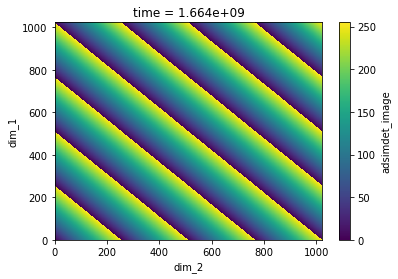

In [27]:
frame.plot.pcolormesh()

In [28]:
run.primary._resources

[Resource({'path_semantics': 'posix',
 'resource_kwargs': {'frame_per_point': 5},
 'resource_path': 'tmp/docker_ioc/iocad/tmp/example/2022/09/27/de3362ec-5271-4715-a03e_000000.h5',
 'root': '/',
 'run_start': 'df16fb86-e3f5-4f3e-a423-fdd7f3ab01a3',
 'spec': 'AD_HDF5',
 'uid': '6c233353-215e-433c-a100-beb4e8ccf03f'})]

***Find the image file on local disk***

Get the name of the image file on the bluesky (local) workstation from the `adsimdet` object.

In [29]:
from apstools.devices import AD_full_file_name_local

local_file_name = AD_full_file_name_local(adsimdet.hdf1)
print(f"{local_file_name.exists()=}\n{local_file_name=}")

local_file_name.exists()=True
local_file_name=PosixPath('/tmp/docker_ioc/iocad/tmp/example/2022/09/27/de3362ec-5271-4715-a03e_000000.h5')


Alternatively, we might get the name of the file from the run stream.

In [30]:
rsrc = run.primary._resources[0]
fname = pathlib.Path(f"{rsrc['root']}{rsrc['resource_path']}")
print(f"{fname.exists()=}\n{fname=}")

# confirm they are the same
print(f"{(local_file_name == fname)=}")

fname.exists()=True
fname=PosixPath('/tmp/docker_ioc/iocad/tmp/example/2022/09/27/de3362ec-5271-4715-a03e_000000.h5')
(local_file_name == fname)=True


## punx

Next, we demonstrate access to the HDF5 image file using the [punx](https://punx.readthedocs.io) program.

***details***

We run `punx` from within the notebook to read this HDF5 file and shows its tree structure.  (Since we can't easily pass a Python object to the notebook magic command `!` which executes a shell command, we'll call a library routine from [apstools](https://apstools.readthedocs.io/en/latest/api/_utils.html?highlight=unix#apstools.utils.misc.unix) to make this work.)

In [31]:
from apstools.utils import unix

for line in unix(f"punx tree {local_file_name}"):
    print(line.decode().strip())

!!! WARNING: this program is not ready for distribution.

/tmp/docker_ioc/iocad/tmp/example/2022/09/27/de3362ec-5271-4715-a03e_000000.h5 : NeXus data file
  entry:NXentry
    @NX_class = "NXentry"
    data:NXdata
      @NX_class = "NXdata"
      data:NX_UINT8[5,1024,1024] = __array
        __array = [
            [
                [1, 2, 3, '...', 0]
                [2, 3, 4, '...', 1]
                [3, 4, 5, '...', 2]
                ...
                [0, 1, 2, '...', 255]
              ]
            [
                [2, 3, 4, '...', 1]
                [3, 4, 5, '...', 2]
                [4, 5, 6, '...', 3]
                ...
                [1, 2, 3, '...', 0]
              ]
            [
                [3, 4, 5, '...', 2]
                [4, 5, 6, '...', 3]
                [5, 6, 7, '...', 4]
                ...
                [2, 3, 4, '...', 1]
              ]
            [
                [4, 5, 6, '...', 3]
                [5, 6, 7, '...', 4]
                [6, 7, 8, '

## Recapitulation

Let's gather the above parts together as one would usually write code.  First, all the imports, constants, and classes.

In [32]:
# matplotlib graphics, choices include: inline, notebook, auto
%matplotlib inline

from apstools.devices import AD_full_file_name_local
from apstools.devices import AD_plugin_primed
from apstools.devices import AD_prime_plugin2
from apstools.devices import CamMixin_V34
from apstools.devices import SingleTrigger_V34
from bluesky.callbacks.best_effort import BestEffortCallback
from ophyd import ADComponent
from ophyd.areadetector import DetectorBase
from ophyd.areadetector import SimDetectorCam
from ophyd.areadetector.filestore_mixins import FileStoreHDF5IterativeWrite
from ophyd.areadetector.plugins import HDF5Plugin_V34 as HDF5Plugin
from ophyd.areadetector.plugins import ImagePlugin_V34 as ImagePlugin
import bluesky
import bluesky.plans as bp
import databroker
import hdf5plugin  # for LZ4, Blosc, or other compression codecs (not already in h5py)
import matplotlib.pyplot as plt
import pathlib

plt.ion()  # turn on matplotlib plots
IOC = "ad:"

AD_IOC_MOUNT_PATH = pathlib.Path("/tmp")
BLUESKY_MOUNT_PATH = pathlib.Path("/tmp/docker_ioc/iocad/tmp")
IMAGE_DIR = "example/%Y/%m/%d"

# MUST end with a `/`, pathlib will NOT provide it
WRITE_PATH_TEMPLATE = f"{AD_IOC_MOUNT_PATH / IMAGE_DIR}/"
READ_PATH_TEMPLATE = f"{BLUESKY_MOUNT_PATH / IMAGE_DIR}/"

class SimDetectorCam_V34(CamMixin_V34, SimDetectorCam):
    """Revise SimDetectorCam for ADCore revisions."""

class MyHDF5Plugin(FileStoreHDF5IterativeWrite, HDF5Plugin):
    """
    Add data acquisition methods to HDF5Plugin.

    * ``stage()`` - prepare device PVs befor data acquisition
    * ``unstage()`` - restore device PVs after data acquisition
    * ``generate_datum()`` - coordinate image storage metadata
    """

    def stage(self):
        self.stage_sigs.move_to_end("capture", last=True)
        super().stage()

class SimDetector_V34(SingleTrigger_V34, DetectorBase):
    """
    ADSimDetector

    SingleTrigger:

    * stop any current acquisition
    * sets image_mode to 'Multiple'
    """

    cam = ADComponent(SimDetectorCam_V34, "cam1:")
    hdf1 = ADComponent(
        MyHDF5Plugin,
        "HDF1:",
        write_path_template=WRITE_PATH_TEMPLATE,
        read_path_template=READ_PATH_TEMPLATE,
    )
    image = ADComponent(ImagePlugin, "image1:")

Next, create and configure the Python object for the detector:

In [33]:
adsimdet = SimDetector_V34(IOC, name="adsimdet")
adsimdet.wait_for_connection(timeout=15)
adsimdet.missing_plugins()  # confirm all plugins are defined

adsimdet.read_attrs.append("hdf1")  # include `hdf1` plugin with 'adsimdet.read()'
adsimdet.hdf1.create_directory.put(-5)  # IOC may create up to 5 new subdirectories, as needed

# override default settings from ophyd
adsimdet.cam.stage_sigs["wait_for_plugins"] = "Yes"
adsimdet.hdf1.stage_sigs["blocking_callbacks"] = "No"
adsimdet.image.stage_sigs["blocking_callbacks"] = "No"

# apply some of our own customizations
NUM_FRAMES = 5
adsimdet.cam.stage_sigs["acquire_period"] = 0.002
adsimdet.cam.stage_sigs["acquire_time"] = 0.001
adsimdet.cam.stage_sigs["num_images"] = NUM_FRAMES
adsimdet.hdf1.stage_sigs["num_capture"] = 0  # capture ALL frames received
adsimdet.hdf1.stage_sigs["compression"] = "zlib"  # LZ4
# adsimdet.hdf1.stage_sigs["queue_size"] = 20

# this step is needed for ophyd
if not AD_plugin_primed(adsimdet.hdf1):
    print(f"Priming {adsimdet.hdf1.dotted_name}")
    AD_prime_plugin2(adsimdet.hdf1)

Prepare for data acquisition.

In [34]:
cat = databroker.temp().v2  # or use your own catalog: databroker.catalog["CATALOG_NAME"]
RE = bluesky.RunEngine({})
RE.subscribe(cat.v1.insert)
RE.subscribe(BestEffortCallback())
RE.preprocessors.append(bluesky.SupplementalData())

Take an image.

In [35]:
uids = RE(
    bp.count(
        [adsimdet],
        md=dict(
            title="Area Detector with default HDF5 File Name",
            purpose="image",
            image_file_name_style="ophyd(uid)",
        )
    )
)

# confirm the plugin captured the expected number of frames
assert adsimdet.hdf1.num_captured.get() == NUM_FRAMES

# Show the image file name on the bluesky (local) workstation
# Use information from the 'adsimdet' object
local_file_name = AD_full_file_name_local(adsimdet.hdf1)
print(f"{local_file_name.exists()=} {local_file_name=}")



Transient Scan ID: 1     Time: 2022-09-27 10:59:05
Persistent Unique Scan ID: '91efb8b6-1b36-499b-b16a-dc9c131b23ca'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 10:59:05.6 |
+-----------+------------+
generator count ['91efb8b6'] (scan num: 1)



local_file_name.exists()=True local_file_name=PosixPath('/tmp/docker_ioc/iocad/tmp/example/2022/09/27/f631740c-1baa-46fb-8f05_000000.h5')


View the image using databroker.

fname.exists()=True
fname=PosixPath('/tmp/docker_ioc/iocad/tmp/example/2022/09/27/f631740c-1baa-46fb-8f05_000000.h5')
(local_file_name == fname)=True


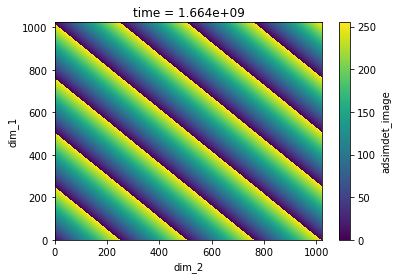

In [36]:
run = cat.v2[uids[0]]
dataset = run.primary.read()
dataset["adsimdet_image"][0][0].plot.pcolormesh()

# Show the image file name on the bluesky (local) workstation
# Use information from the databroker run
_r = run.primary._resources[0]
fname = pathlib.Path(f"{_r['root']}{_r['resource_path']}")
print(f"{fname.exists()=}\n{fname=}")

# confirm the name above () is the same
print(f"{(local_file_name == fname)=}")